# Isotropic damage in a quarter plate 

Credits to Wiliams Ye!

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/solid/plate_damage.ipynb)

In [1]:
import torch

from torchfem.examples import get_example_file
from torchfem.io import import_mesh
from torchfem.materials import IsotropicDamage3D

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

## Material 

The material is elastic up to an equivalent strain (max. principal strain) of $\varepsilon_0$=0.0002. From there on, the damage evolution is computed with a strain softening exponential law. The fracture energy per unit area is 
$$
G_\textrm{f} = l_\textrm{c} \int_{\varepsilon_0}^{\infty} \sigma d \varepsilon = 0.048
$$
with the characteristic element length $l_c$.

In [2]:
# Elastic parameters (Young's modulus and Poisson's ratio)
E = 6000.0
nu = 0.3

# Damage parameters (Damage initiation strain and fracture energy)
eps_0 = 2.0e-4
G_f = 0.048


def d(kappa, cl):
    # Damage evolution law for exponential strain softening
    eps_f = G_f / (E * eps_0 * cl) + eps_0 / 2.0
    evolution = 1.0 - eps_0 / kappa * torch.exp(-(kappa - eps_0) / (eps_f - eps_0))
    evolution[kappa < eps_0] = 0.0

    return evolution


def d_prime(kappa, cl):
    # Derivative of the damage evolution law
    eps_f = G_f / (E * eps_0 * cl) + eps_0 / 2.0
    derivative = (
        eps_0
        * torch.exp(-(kappa - eps_0) / (eps_f - eps_0))
        * (1 / kappa**2 + 1 / (kappa * (eps_f - eps_0)))
    )
    derivative[kappa < eps_0] = 0.0

    return derivative


# Elastic properties
material = IsotropicDamage3D(E, nu, d, d_prime, "rankine")

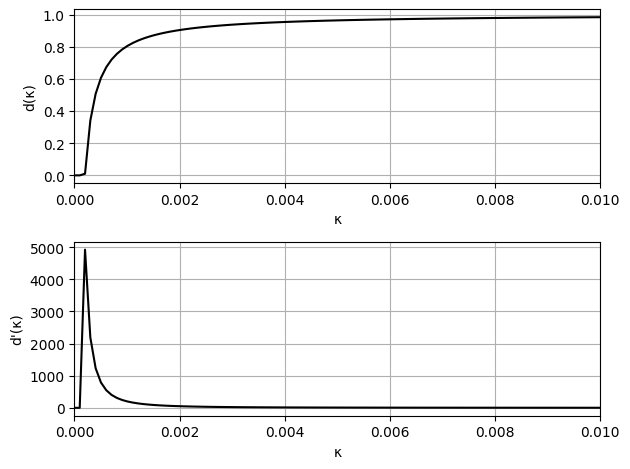

In [3]:
kappa_test = torch.linspace(0.0, 0.01, 100)

fig, ax = plt.subplots(2, 1)
ax[0].plot(kappa_test, d(kappa_test, 1.0), "-k")
ax[0].set_xlim(0.0, 0.01)
ax[0].set_xlabel("κ")
ax[0].set_ylabel("d(κ)")
ax[0].grid()
ax[1].plot(kappa_test, d_prime(kappa_test, 1.0), "-k")
ax[1].set_xlim(0.0, 0.01)
ax[1].set_xlabel("κ")
ax[1].set_ylabel("d'(κ)")
ax[1].grid()
plt.tight_layout()
plt.show()

## Quarter Plate Model

The solid model is imported from the example files. It is loaded in the 1-direction with a displacement boundary condition, the other boundaries are either symmetry conditions or free. 

In [4]:
model = import_mesh(get_example_file("quarter_plate_hole_3d.vtu"), material)

# Regions
left = model.nodes[:, 0] <= 0.1
bottom = model.nodes[:, 1] <= 0.1
top = model.nodes[:, 1] >= 99.9
back = model.nodes[:, 2] <= 0.1

# Boundary conditions
model.constraints[left, 0] = True
model.constraints[bottom, 1] = True
model.constraints[back, 2] = True
model.constraints[top, 1] = True
model.displacements[top, 1] = 0.05

# Increments
increments = torch.linspace(0.0, 1.0, 50)

# Visualize quarter plate
model.plot()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Solve

This may take up to 2 minutes.

In [5]:
u, f, σ, F, α = model.solve(increments=increments, return_intermediate=True)

# Compute infinitesimal strain
H = F - torch.eye(3)
ε = 0.5 * (H.transpose(-1, -2) + H)

## Results 

In this case, the damage initiates at the highest stress concentration at the hole and then propagates transverse to the load direction throughout the part. 

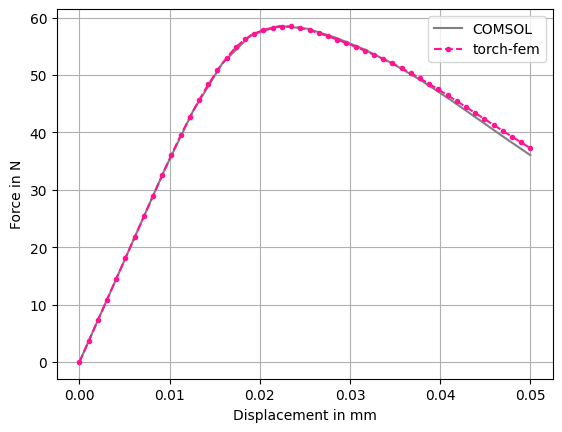

In [6]:
# Reference solution from COMSOL (obtained at higher resolution)
reference = torch.tensor(
    [
        [0.000e00, 0.000e00],
        [3.164e-03, 1.123e01],
        [6.329e-03, 2.246e01],
        [9.493e-03, 3.366e01],
        [1.265e-02, 4.389e01],
        [1.582e-02, 5.200e01],
        [1.898e-02, 5.696e01],
        [2.215e-02, 5.857e01],
        [2.531e-02, 5.808e01],
        [2.848e-02, 5.649e01],
        [3.164e-02, 5.444e01],
        [3.481e-02, 5.193e01],
        [3.797e-02, 4.899e01],
        [4.113e-02, 4.570e01],
        [4.430e-02, 4.223e01],
        [4.746e-02, 3.875e01],
        [4.999e-02, 3.605e01],
    ]
)

plt.plot(reference[:, 0], reference[:, 1], "-", label="COMSOL", color="gray")
plt.plot(
    u[:, top, 1].mean(dim=-1),
    f[:, top, 1].sum(dim=-1),
    ".--",
    label="torch-fem",
    color="deeppink",
)
plt.xlabel("Displacement in mm")
plt.ylabel("Force in N")
plt.grid()
plt.legend()
plt.show()

In [7]:
model.plot(u=u[-1], element_property={"Damage": α[-1, :, 1]}, cmap="Blues")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…